In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

from collections import Counter

from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
train = pd.read_csv('Data/train.csv', index_col = False).fillna(0)
if 'Unnamed: 0' in train.columns:
    train.drop(columns=['Unnamed: 0'], inplace  =True)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,48,9,25,13,3,11,27,13,36,10


In [3]:
page = train.iloc[38573:38574,:]

dates = page.columns[1:-1]
dates = '\"' + dates + '\"'
dates = [dt.strptime(date, '"%Y-%m-%d"').date() for date in dates]

data = page.iloc[:, 1:-1].values[0]

page_name = page.iloc[:, 0:1].values[0]

In [8]:
page.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
38573,Main_Page_en.wikipedia.org_all-access_all-agents,20381245,20752194,19573967,20439645,20772109,22544669,21210887,19107911,19993848,...,24201081,22539246,25056620,25865746,28342885,26916991,27025053,26073819,24363967,26149541


In [42]:
df = pd.DataFrame(
    {'Dates': dates,
    'Data': data
    }
)

In [43]:
df.index = df.Dates

In [46]:
df.drop(columns=['Dates'], inplace=True)

In [53]:
dta = df.Data

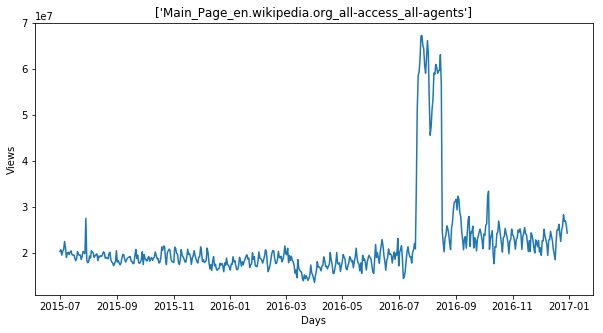

In [5]:
fig = plt.figure(1,figsize=(10,5))

plt.plot(dates, data)
plt.xlabel('Days')
plt.ylabel('Views')
plt.title(page_name)
plt.show()

Text(0.5, 0, 'Lag')

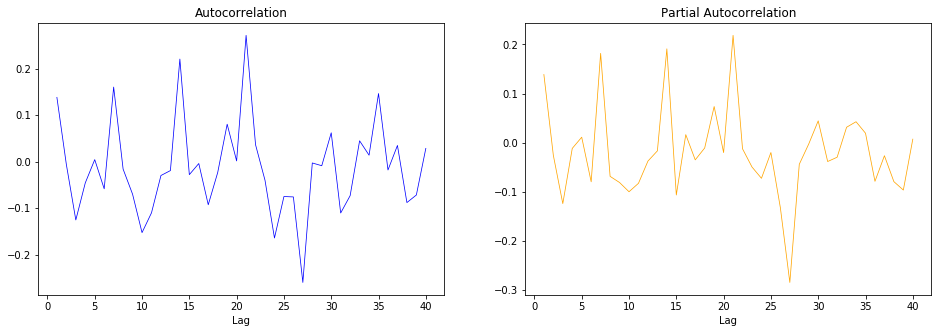

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5));

line_width = 0.75

ax11 = axes[0]
ax12 = axes[1]

data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
autocorr = acf(data_diff)
pac = pacf(data_diff)

x = [x for x in range(len(pac))]
ax11.plot(x[1:],autocorr[1:], c='blue', lw=line_width)

ax12.plot(x[1:],pac[1:], c='orange', lw=line_width)


ax11.set_title('Autocorrelation')
ax12.set_title('Partial Autocorrelation')

ax12.set_xlabel('Lag')
ax11.set_xlabel('Lag')

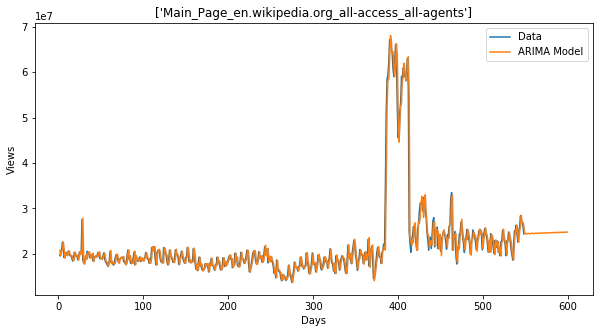

In [7]:
result = None
try:
    arima = ARIMA(data,[2,1,4])
    result = arima.fit(disp=False)
except:
    try:
        arima = ARIMA(data,[2,1,2])
        result = arima.fit(disp=False)
    except:
        print(page_name)
        print('\tARIMA failed')
# print(result.params)
pred = result.predict(2,599,typ='levels')
x = [i for i in range(600)]
i=0

fig = plt.figure(1,figsize=(10,5))
plt.plot(x[2:len(data)],data[2:] ,label='Data')
plt.plot(x[2:],pred,label='ARIMA Model')
plt.title(page_name)
plt.xlabel('Days')
plt.ylabel('Views')
plt.legend()
plt.show()

In [21]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [27]:
mod_hamilton = MarkovAutoregression(data, k_regimes=2, order=4, switching_ar=False)
#         result = mod_hamilton.fit(data)

# pred = mod_hamilton.predict(2,599)
# x = [i for i in range(600)]
# i=0

#     plt.plot(x[2:len(data)],data[2:] ,label='Data')
#     plt.plot(x[2:],pred,label='Markov Switch Model')
#     plt.title(train.loc[top_pages[key],'Page'])
#     plt.xlabel('Days')
#     plt.ylabel('Views')
#     plt.legend()
#     plt.show()

In [54]:
# Get the RGNP data to replicate Hamilton
# dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
# dta.index = pd.DatetimeIndex(dta.date, freq='QS')
# dta_hamilton = dta.rgnp

# dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [37]:
# res_hamilton.summary()

[Text(0.5, 1.0, 'Real values')]

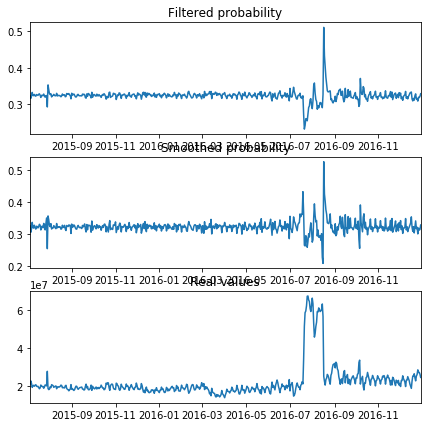

In [57]:
# %matplotlib inline

# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# import requests
# from io import BytesIO

# # NBER recessions
# from pandas_datareader.data import DataReader
# from datetime import datetime
# usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))

fig, axes = plt.subplots(3, figsize=(7,7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.set_xlim(dta.index[4], dta.index[-1])
ax.set(title='Filtered probability')

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.set_xlim(dta.index[4], dta.index[-1])
ax.set(title='Smoothed probability')

ax = axes[2]
ax.plot(dates, data)
ax.set_xlim(dta.index[4], dta.index[-1])
ax.set(title='Real values')